<a href="https://colab.research.google.com/github/elli-saberi/Amazon-reviews-sentiment-analysis/blob/feature%2Fwarranty-sentiment-analysis/part2_warranty_sentiment_analysis_using_sentence_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time


In [ ]:
!pip install -q sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"Model '{model_name}' loaded successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully!


Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/sentiment analysis-ph2p1/cleaned_balanced_data.csv'
brand_path = '/content/drive/My Drive/sentiment analysis-ph2p1/title_brand.csv'

train_df = pd.read_csv(train_path)
brand_df = pd.read_csv(brand_path)

In [ ]:
print(train_df.columns)

Index(['asin', 'fullText', 'overall'], dtype='object')


A small test to understand the sentence embedding model's output

In [ ]:
# A list of sentences to encode
sentences_to_encode = [
    "This product comes with a one-year warranty.",
    "The customer support was excellent, they replaced it immediately.",
    "The camera quality is amazing, especially in low light."

]

# Use the model to encode the sentences into embeddings
sentence_embeddings = model.encode(sentences_to_encode)

# Let's check the output
for sentence, embedding in zip(sentences_to_encode, sentence_embeddings):
    print(f"Sentence: {sentence}")
    # The embedding is a numpy array. Let's check its shape.
    print(f"Embedding Shape: {embedding.shape}")
    # Let's print the first 5 elements to get a feel for it
    print(f"Embedding Preview: {embedding[:5]}")
    print("-" * 30)

# Also check the shape of the entire output matrix
print(f"\nShape of the final embeddings matrix: {sentence_embeddings.shape}")


Sentence: This product comes with a one-year warranty.
Embedding Shape: (384,)
Embedding Preview: [-0.07242988 -0.01720056  0.11028782 -0.03272755 -0.02591415]
------------------------------
Sentence: The customer support was excellent, they replaced it immediately.
Embedding Shape: (384,)
Embedding Preview: [-0.1098006   0.06878014  0.04986232 -0.05591362 -0.0504061 ]
------------------------------
Sentence: The camera quality is amazing, especially in low light.
Embedding Shape: (384,)
Embedding Preview: [-0.01528103  0.01013591  0.03823137 -0.03586568 -0.01068276]
------------------------------

Shape of the final embeddings matrix: (3, 384)


In [ ]:
# Let's grab the list of all reviews
reviews_list = train_df['fullText'].tolist()

# Start the timer
start_time = time.time()

# Encode the reviews.
review_embeddings = model.encode(reviews_list, show_progress_bar=False, batch_size=128)

# Stop the timer
end_time = time.time()

print(f"\nEncoding finished in {end_time - start_time:.2f} seconds.")

#check the shape of our final embeddings matrix
print(f"Shape of the review_embeddings matrix: {review_embeddings.shape}")



Encoding finished in 426.97 seconds.
Shape of the review_embeddings matrix: (386845, 384)


In [ ]:
# Our target concept, described by a RICH set of phrases
query_phrases = [
    'product warranty and guarantee',
    'customer support for replacement or repair',
    'return policy and money back',
    'defective item and exchange process',

    'lifetime warranty',
    'limited warranty terms',
    'one-year warranty coverage',

    'helpful and responsive customer service',
    'contacting support was easy',
    'they never replied to my email',
    'long wait time for support',

    'the device stopped working after a week',
    'it was broken on arrival (DOA - Dead on Arrival)',
    'product malfunction and failure',

    'getting a full refund was straightforward',
    'return merchandise authorization (RMA) process'
]
query_embeddings = model.encode(query_phrases)
print(f"Number of query phrases: {len(query_phrases)}")
print(f"Shape of the new query_embeddings matrix: {query_embeddings.shape}")



Number of query phrases: 16
Shape of the new query_embeddings matrix: (16, 384)


In [ ]:
from sentence_transformers import util

cosine_scores = util.cos_sim(query_embeddings, review_embeddings)

print("Cosine similarity calculation finished.")
print(f"Shape of the cosine_scores matrix: {cosine_scores.shape}")

Cosine similarity calculation finished.
Shape of the cosine_scores matrix: torch.Size([16, 386845])


In [ ]:
import torch

# For each review (column), find the maximum score it got against any of our queries (rows)
# We use .max(dim=0) to find the max value in each column.
# The result is a tensor of max scores and a tensor of indices. We only need the .values
max_scores_per_review = torch.max(cosine_scores, dim=0).values

# Add these scores as a new column to our original dataframe
train_df['warranty_similarity_score'] = max_scores_per_review

print("Added 'warranty_similarity_score' column to the dataframe.")

# Let's see the reviews with the highest scores
print("\nTop 5 reviews with the highest similarity score:")
display(train_df.sort_values(by='warranty_similarity_score', ascending=False).head(5)[['fullText', 'warranty_similarity_score']])



Added 'warranty_similarity_score' column to the dataframe.

Top 5 reviews with the highest similarity score:


,fullText,warranty_similarity_score
14041,broke month purchased long time ago ended able...,0.737172
106788,stopped working months 1year warranty device s...,0.733309
2057,device stopped working within two months cant ...,0.733103
37522,device stopped working within two months cant ...,0.733103
136831,stopped working worked fine week stopped conne...,0.731843


Visualize the distribution of the similarity scores

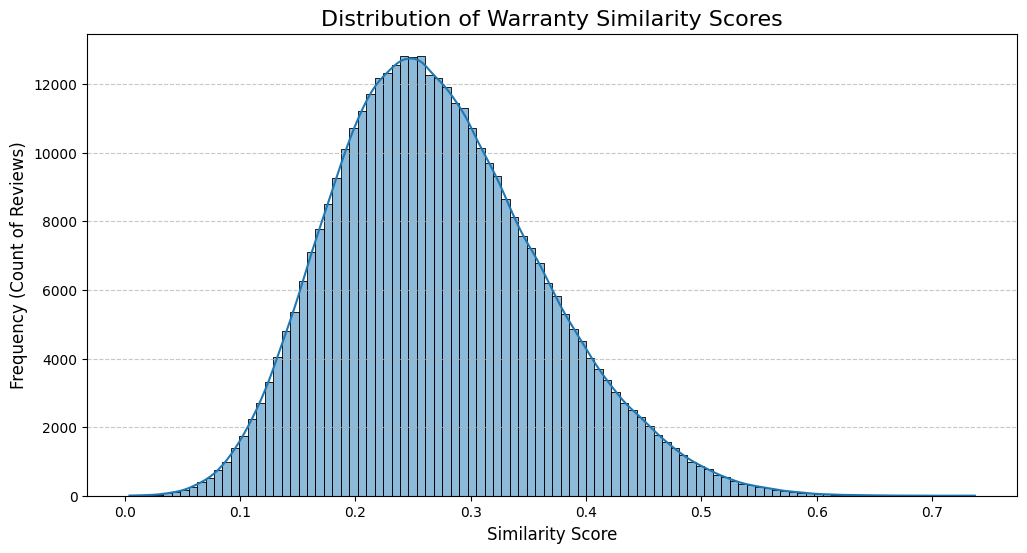

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='warranty_similarity_score', bins=100, kde=True)

plt.title('Distribution of Warranty Similarity Scores', fontsize=16)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency (Count of Reviews)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Filter reviews based on the similarity score threshold

In [ ]:
THRESHOLD = 0.5

# Create a new dataframe containing only the reviews that meet our threshold.
warranty_reviews_df = train_df[train_df['warranty_similarity_score'] >= THRESHOLD].copy()

# Print the results to see how many reviews we have filtered
print(f"Total number of reviews in the original dataset: {len(train_df):,}")
print(f"Number of warranty-related reviews found (score >= {THRESHOLD}): {len(warranty_reviews_df):,}")
print(f"Percentage of relevant reviews: {len(warranty_reviews_df) / len(train_df):.2%}")


#Sanity Check: Inspect the reviews near the threshold
# We look at the reviews with the LOWEST scores that still passed our filter.
# If these reviews are relevant, our threshold is good. If they are irrelevant, it's too low.
print("\n Sanity Check: 10 Reviews with Scores Just Above the Threshold")
display(warranty_reviews_df.sort_values('warranty_similarity_score').head(10)[['fullText', 'overall', 'warranty_similarity_score']])


Total number of reviews in the original dataset: 386,845
Number of warranty-related reviews found (score >= 0.5): 4,627
Percentage of relevant reviews: 1.20%

 Sanity Check: 10 Reviews with Scores Just Above the Threshold


,fullText,overall,warranty_similarity_score
74031,invest better quality cable one cable little y...,1,0.500020
76121,waste time money customer service completely u...,1,0.500024
84552,item great first item great first never used m...,2,0.500030
140144,product stands alone without sorry customer su...,3,0.500060
25728,poor support errors card immediately started g...,1,0.500072
36389,dont thought would review help save frustratio...,1,0.500091
77725,perform using little month found product work ...,1,0.500094
139293,good product bad customer tech support asus go...,2,0.500098
38042,honor warranty works notifications good use se...,1,0.500100
105302,stops working weeks happy persons good opinion...,2,0.500102


Calculate the final sentiment score for the warranty aspect of each product

In [ ]:
# First, check if the filtered dataframe is not empty
if not warranty_reviews_df.empty:
    # Group the filtered dataframe by 'asin'
    # For each product, calculate the mean of the 'overall' score and the number of reviews ('count')
    warranty_sentiment_by_product = warranty_reviews_df.groupby('asin')['overall'].agg(['mean', 'count']).reset_index()

    # Rename the columns for better clarity
    warranty_sentiment_by_product = warranty_sentiment_by_product.rename(columns={
        'mean': 'avg_warranty_sentiment',
        'count': 'warranty_review_count'
    })

    # Sort the results to see the products with the highest satisfaction in their warranty/support
    print("\n Top 10 Products by Average Warranty Sentiment")
    # We only show products with more than 1 warranty review to make the average more reliable
    display(warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=False).head(10))

    # Sort the results to see the products with the lowest satisfaction
    print("\n Bottom 10 Products by Average Warranty Sentiment")
    display(warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=True).head(10))
else:
    print(f"\nNo reviews found with a similarity score above the threshold of {THRESHOLD}. Try lowering the threshold.")



 Top 10 Products by Average Warranty Sentiment


,asin,avg_warranty_sentiment,warranty_review_count
2036,B00YBC8I66,5.000000,2
2856,B01B4W40VC,4.666667,3
1255,B00L23ZTNM,4.500000,2
2413,B0151RKYBG,4.500000,2
646,B00C30FCUI,4.500000,2
1609,B00QTE09SY,4.250000,4
628,B00BT8KZCU,4.000000,3
825,B00EYDTA3W,4.000000,2
489,B008YD80KC,4.000000,2
735,B00DQOG1UA,4.000000,2



 Bottom 10 Products by Average Warranty Sentiment


,asin,avg_warranty_sentiment,warranty_review_count
3289,B01HETFQKI,1.0,2
3285,B01HCVG51M,1.0,4
3280,B01H9TA1T4,1.0,2
85,B000VM60I8,1.0,4
88,B000XJLLKG,1.0,2
86,B000VS4HDM,1.0,4
90,B000XPS3U6,1.0,2
3275,B01H6I3YGK,1.0,2
99,B0015BYQJE,1.0,2
100,B0015DYMVO,1.0,2


Merging results with product metadata

In [ ]:

final_results_df = pd.merge(
    left=warranty_sentiment_by_product,
    right=brand_df,
    on='asin',
    how='left'
)
print(f"Merge complete. Shape of the final dataframe: {final_results_df.shape}")



final_results_df['brand'] = final_results_df['brand'].fillna('N/A')
final_results_df['title'] = final_results_df['title'].fillna('Unknown Title')


final_results_df['product_link'] = 'https://www.amazon.com/dp/' + final_results_df['asin']



display_columns = [
    'brand',
    'title',
    'avg_warranty_sentiment',
    'warranty_review_count',
    'product_link'
]


min_reviews_threshold = 2
reliable_results_df = final_results_df[final_results_df['warranty_review_count'] >= min_reviews_threshold].copy()


print(f"\n✅ Top 10 Products by Warranty Sentiment (with at least {min_reviews_threshold} reviews)")
top_10 = reliable_results_df.sort_values(by='avg_warranty_sentiment', ascending=False).head(10)

display(top_10[display_columns])


print(f"\n❌ Bottom 10 Products by Warranty Sentiment (with at least {min_reviews_threshold} reviews)")
bottom_10 = reliable_results_df.sort_values(by='avg_warranty_sentiment', ascending=True).head(10)
display(bottom_10[display_columns])


Merging results with product metadata...
Merge complete. Shape of the final dataframe: (3320, 5)

✅ Top 10 Products by Warranty Sentiment (with at least 2 reviews)


,brand,title,avg_warranty_sentiment,warranty_review_count,product_link
2065,SquareTrade,SquareTrade 3-Year Housewares Extended Protect...,5.000000,2,https://www.amazon.com/dp/B00YBC8I66
2885,TROND,TROND 2-in-1 Bluetooth V5.0 Transmitter Receiv...,4.666667,3,https://www.amazon.com/dp/B01B4W40VC
675,Symphonized,Symphonized NRG Premium Genuine Wood In-ear No...,4.500000,2,https://www.amazon.com/dp/B00C30FCUI
1284,BRAINWAVZ,Brainwavz Delta Black IEM In Ear Earbuds Noise...,4.500000,2,https://www.amazon.com/dp/B00L23ZTNM
2442,TechMatte,"TechMatte Micro USB to USB C Adapter, Converts...",4.500000,2,https://www.amazon.com/dp/B0151RKYBG
1638,iClever,iClever BoostCube 4.8A 24W Dual USB Travel Wal...,4.250000,4,https://www.amazon.com/dp/B00QTE09SY
518,Amcrest,Amcrest Blue Iris Professional Version 4 - Sup...,4.000000,2,https://www.amazon.com/dp/B008YD80KC
3216,AGPTEK,AGPtEK A18 8GB Sport Bluetooth MP3 Player&amp;...,4.000000,2,https://www.amazon.com/dp/B01FVZKDYG
657,Tech Armor,"Tech Armor iPad Mini Glass Screen Protector, P...",4.000000,3,https://www.amazon.com/dp/B00BT8KZCU
854,Snugg,"iPad Air &amp; New iPad 9.7 inch 2017 Case, Sn...",4.000000,2,https://www.amazon.com/dp/B00EYDTA3W



❌ Bottom 10 Products by Warranty Sentiment (with at least 2 reviews)


,brand,title,avg_warranty_sentiment,warranty_review_count,product_link
3318,Bose,Bose SoundLink Color Bluetooth Speaker II - Po...,1.0,2,https://www.amazon.com/dp/B01HETFQKI
3314,iHome,"iHome iSP8 Wi-FI SmartPlug, Use your voice to ...",1.0,4,https://www.amazon.com/dp/B01HCVG51M
3309,Seagate,Seagate Backup Plus 3TB External Desktop Hard ...,1.0,2,https://www.amazon.com/dp/B01H9TA1T4
3304,Avantree,Avantree Oasis Long Range Bluetooth Transmitte...,1.0,2,https://www.amazon.com/dp/B01H6I3YGK
3300,TESSAN,TESSAN Portable 2 Outlet Travel Power Strip wi...,1.0,2,https://www.amazon.com/dp/B01H4YTHWG
3278,TaoTronics,TaoTronics Pulse X Bluetooth Speaker Bluetooth...,1.0,2,https://www.amazon.com/dp/B01GPIES08
115,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,1.0,4,https://www.amazon.com/dp/B000VS4HDM
114,Diamond Multimedia,Diamond VC500 USB 2.0 One Touch VHS to DVD Vid...,1.0,4,https://www.amazon.com/dp/B000VM60I8
119,HDE,HDE USB 2.0 Aluminum External Hard Drive Enclo...,1.0,2,https://www.amazon.com/dp/B000XPS3U6
3260,Logitech,Logitech - M325c Wireless Optical Mouse - Red ...,1.0,4,https://www.amazon.com/dp/B01GI93F76
